# Fine-tuning InceptionV3 for flowers classification

In this task you will fine-tune InceptionV3 architecture for flowers classification task.

InceptionV3 architecture (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html):
<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week3/images/inceptionv3.png?raw=1" style="width:70%">

Flowers classification dataset (http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) consists of 102 flower categories commonly occurring in the United Kingdom. Each class contains between 40 and 258 images:
<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week3/images/flowers.jpg?raw=1" style="width:70%">

# Import stuff

In [24]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
import cv2  # for image processing
from sklearn.model_selection import train_test_split
import scipy.io
import os
import tarfile

2.3.1


# Load dataset

Dataset is about 400mb. Put these 2 files (.tgz and .mat) in the same notebook folder.
Relevant links:
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html (Index)
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

# Prepare images for model

In [2]:
# we will crop and resize input images to IMG_SIZE x IMG_SIZE
IMG_SIZE = 250

In [3]:
def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

We will take a center crop from each image like this:

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week3/images/center_crop.jpg?raw=1" style="width:50%">

In [4]:
def image_center_crop(img):
    """
    Makes a square center crop of an img, which is a [h, w, 3] numpy array.
    Returns [min(h, w), min(h, w), 3] output with same width and height.
    For cropping use numpy slicing.
    """
    
    h, w = img.shape[0], img.shape[1]
    m = min(h, w)
    cropped_img = img[(h-m)//2:(h+m)//2, (w-m)//2:(w+m)//2, :]
    
    return cropped_img

In [5]:
def prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=True):
    img = decode_image_from_raw_bytes(raw_bytes)  # decode image raw bytes to matrix
    img = image_center_crop(img)  # take squared center crop
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # resize for our model
    if normalize_for_model:
        img = img.astype("float32")  # prepare for normalization
        img = tf.keras.applications.inception_v3.preprocess_input(img)  # normalize for model
    return img

In [6]:
# reads bytes directly from tar by filename (slow, but ok for testing, takes ~6 sec)
def read_raw_from_tar(tar_fn, fn):
    with tarfile.open(tar_fn) as f:
        m = f.getmember(fn)
        return f.extractfile(m).read()

(500, 591, 3)


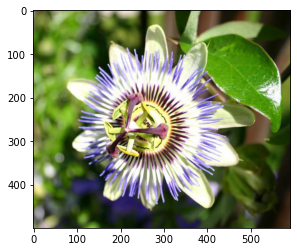

(250, 250, 3)


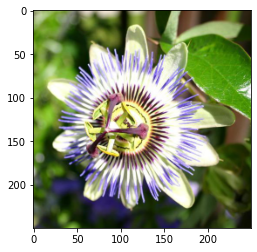

In [7]:
# test cropping
raw_bytes = read_raw_from_tar("102flowers.tgz", "jpg/image_00001.jpg")

img = decode_image_from_raw_bytes(raw_bytes)
print(img.shape)
plt.imshow(img)
plt.show()

img = prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=False)
print(img.shape)
plt.imshow(img)
plt.show()

# Prepare for training

In [8]:
# read all filenames and labels for them

# read filenames firectly from tar
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

# list all files in tar sorted by name
all_files = sorted(get_all_filenames("102flowers.tgz")) 
# read class labels (0, 1, 2, ...)
all_labels = scipy.io.loadmat('imagelabels.mat')['labels'][0] - 1  

# all_files and all_labels are aligned now
N_CLASSES = len(np.unique(all_labels))
print(N_CLASSES)

102


In [9]:
# split into train/test
tr_files, te_files, tr_labels, te_labels = \
    train_test_split(all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

In [10]:
# will yield raw image bytes from tar with corresponding label
def raw_generator_with_label_from_tar(tar_fn, files, labels):
    label_by_fn = dict(zip(files, labels))
    with tarfile.open(tar_fn) as f:
        while True:
            m = f.next()
            if m is None:
                break
            if m.name in label_by_fn:
                yield f.extractfile(m).read(), label_by_fn[m.name]

In [11]:
# batch generator
BATCH_SIZE = 32

def batch_generator(items, batch_size):
    """
    Implement batch generator that yields items in batches of size batch_size.
    There's no need to shuffle input items, just chop them into batches.
    Remember about the last batch that can be smaller than batch_size!
    Input: any iterable (list, generator, ...). You should do `for item in items: ...`
        In case of generator you can pass through your items only once!
    Output: In output yield each batch as a list of items.
    """
    
    ###
    batch = []
    for i, item in enumerate(items):
        batch.append(item)
        if i % batch_size == batch_size-1:
            yield batch
            batch = []
    # return last (incomplete) batch
    if batch[0]:
        yield [item for item in batch if item]

In [12]:
# Test batch generator
def _test_items_generator():
    for i in range(10):
        yield i

print(list(map(lambda x: len(x), batch_generator(_test_items_generator(), 3))))

[3, 3, 3, 1]


In [13]:
def train_generator(files, labels):
    while True:  # so that Keras can loop through this as long as it wants
        for batch in batch_generator(raw_generator_with_label_from_tar(
                "102flowers.tgz", files, labels), BATCH_SIZE):
            # prepare batch images
            batch_imgs = []
            batch_targets = []
            for raw, label in batch:
                img = prepare_raw_bytes_for_model(raw)
                batch_imgs.append(img)
                batch_targets.append(label)
            # stack images into 4D tensor [batch_size, img_size, img_size, 3]
            batch_imgs = np.stack(batch_imgs, axis=0)
            # convert targets into 2D tensor [batch_size, num_classes]
            batch_targets = tf.keras.utils.to_categorical(batch_targets, N_CLASSES)
            yield batch_imgs, batch_targets

(32, 250, 250, 3) (32, 102)


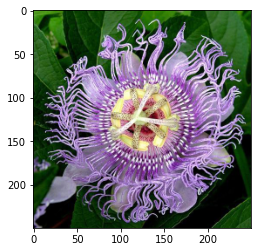

In [14]:
# test training generator
for _ in train_generator(tr_files, tr_labels):
    print(_[0].shape, _[1].shape)
    plt.imshow(np.clip(_[0][0] / 2. + 0.5, 0, 1))
    break

# Training

You cannot train such a huge architecture from scratch with such a small dataset.

But using fine-tuning of last layers of pre-trained network you can get a pretty good classifier very quickly.

In [15]:
def inception(use_imagenet=True):
    # load pre-trained model graph, don't add final layer
    model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                          weights='imagenet' if use_imagenet else None)
    # add global pooling just like in InceptionV3
    new_output = tf.keras.layers.GlobalAveragePooling2D()(model.output)
    # add new dense layer for our labels
    new_output = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(new_output)
    model = tf.python.keras.engine.training.Model(model.inputs, new_output)
    return model

In [16]:
model = inception()

In [17]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 124, 124, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 124, 124, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 124, 124, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [18]:
# how many layers our model has
print(len(model.layers))

313


In [19]:
# set all layers trainable by default
for layer in model.layers:
    layer.trainable = True
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        # we do aggressive exponential smoothing of batch norm
        # parameters to faster adjust to our new dataset
        layer.momentum = 0.9
    
# fix deep layers (fine-tuning only last 50)
for layer in model.layers[:-50]:
    # fix all but batch norm layers, because we neeed to update moving averages for a new dataset!
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

In [20]:
# compile new model
model.compile(
    loss='categorical_crossentropy',  # we train 102-way classification
    optimizer=tf.keras.optimizers.Adamax(lr=1e-2),  # we can take big lr here because we fixed first layers
    metrics=['accuracy']  # report accuracy during training
)

In [21]:
# we will save model checkpoints to continue training in case of kernel death
model_filename = 'flowers.{0:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
# last_finished_epoch = 10
# model = tf.keras.models.load_model(model_filename.format(last_finished_epoch))

Training takes **2 hours**. You're aiming for ~0.93 validation accuracy.

In [25]:
class ModelSaveCallback(keras.callbacks.Callback):

    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        tf.keras.models.save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))


In [26]:
# fine tune for 2 epochs (full passes through all training data)
# we make 2*8 epochs, where epoch is 1/8 of our training data to see progress more often
model.fit_generator(
    train_generator(tr_files, tr_labels), 
    steps_per_epoch=len(tr_files) // BATCH_SIZE // 8,
    epochs=1,#2 * 8,
    validation_data=train_generator(te_files, te_labels), 
    validation_steps=len(te_files) // BATCH_SIZE // 4,
    callbacks=[ModelSaveCallback(model_filename)],
    verbose=1,
    initial_epoch=last_finished_epoch or 0
)

Instructions for updating:
Please use Model.fit, which supports generators.
25/25 [==============================] - 172s 7s/step - loss: 4.4604 - accuracy: 0.2612 - val_loss: 2.7647 - val_accuracy: 0.4089


In [27]:
# Accuracy on validation set
test_accuracy = model.evaluate_generator(
    train_generator(te_files, te_labels), 
    len(te_files) // BATCH_SIZE // 2
)[1]
print(test_accuracy)

Instructions for updating:
Please use Model.evaluate, which supports generators.
0.4074999988079071


That's it! Congratulations!

What you've done:
- prepared images for the model
- implemented your own batch generator
- fine-tuned the pre-trained model